Дан датасет с информацией о клиентах взявших кредит в компании А. Датасет состоит из 3000 записей. колонка target показывает результат кредита (0 - проблемный, 1 - успешный). По данному датасету: 

1. Сделайте предварительный анализ данных. (EDA)
2. Создайте визуализации используя seaborn и matplotlib: графики зависимости, гистограммы, боксплот). Найдите параметр с самой большой корреляцией
3. Создайте модель по данному датасету. (можете использовать scikit или xgboost)
4. Сделайте простейшее веб-приложение, который будет принимать данные клиента и возвращать предсказание модели (используйте flask или fastapi. для деплоя можете использовать heroku (опционально))

Кандидат должен сдать jupyter notebook со всем ходом действий, репозиторий с кодом веб приложения и ссылку на сервис в heroku (если есть)

# Get the data

In [1]:
import pandas as pd
import numpy as np
import os

from datetime import datetime, date

import seaborn as sns
import matplotlib.pyplot as plt

csv_path = os.path.join(os.getcwd(), '../raw_data', 'credit.csv')
      
data = pd.read_csv(csv_path)

data.head()

,birth_date,credit_amount,salary_amount,region,gender,marital_status,credit_history,card_incomes_amount,target
0,08/12/1988,316315800,96800000,tashkent_city,M,married,no_credit_now,114000000,1
1,13/07/1994,237064800,180000000,tashkent_city,M,married,no_credit_now,194483333,1
2,18/12/1988,248900000,350000000,tashkent_city,M,not_married,no_credit_now,237583333,1
3,11/07/1984,235973000,300000000,tashkent_city,M,married,no_credit_now,248283333,1
4,25/03/1991,452710700,700000000,andijan,M,married,no_credit_now,3819750000,1


# Preprocessing

In [2]:
# duplicates are investigated and removed
print('number of duplicated rows: ',data.duplicated().sum())
data = data.drop_duplicates()

number of duplicated rows:  1


In [3]:
# missing values are investigated
data.isnull().sum().sort_values(ascending=False)/len(data)

birth_date             0.0
credit_amount          0.0
salary_amount          0.0
region                 0.0
gender                 0.0
marital_status         0.0
credit_history         0.0
card_incomes_amount    0.0
target                 0.0
dtype: float64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3310 entries, 0 to 3310
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   birth_date           3310 non-null   object
 1   credit_amount        3310 non-null   int64 
 2   salary_amount        3310 non-null   int64 
 3   region               3310 non-null   object
 4   gender               3310 non-null   object
 5   marital_status       3310 non-null   object
 6   credit_history       3310 non-null   object
 7   card_incomes_amount  3310 non-null   object
 8   target               3310 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 258.6+ KB


## Target column analysis: Successful and unsuccessfull credits

In [5]:
# this used for further balancing successfull and unsuccessfull datasets, as can be seen they are unbalanced
df = pd.DataFrame()
df['total_number'] = data.target.value_counts()
df['percentage']   = data.target.value_counts()/len(data)
print(df)
data.groupby('target').mean()

   total_number  percentage
1          2980    0.900302
0           330    0.099698


,credit_amount,salary_amount
target,,
0,4.379764e+08,2.638825e+08
1,4.244330e+08,2.642845e+08


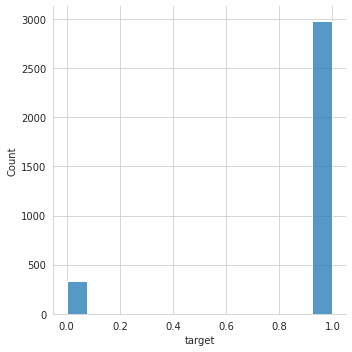

In [6]:
sns.set_style("whitegrid")
sns.displot(data, x="target", shrink=1.)

## Analysis by credit_amount

In [7]:
data.credit_amount.describe()

count    3.310000e+03
mean     4.257833e+08
std      2.229198e+08
min      4.090000e+07
25%      2.866357e+08
50%      4.106100e+08
75%      4.917285e+08
max      2.281500e+09
Name: credit_amount, dtype: float64

Outliers boundary: 812800000.0


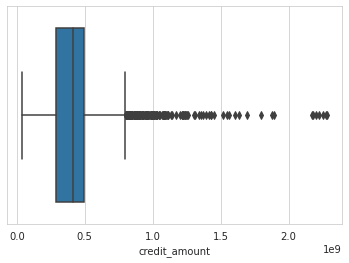

In [8]:
print('Outliers boundary:', data.credit_amount.quantile(0.95))
sns.boxplot(x=data.credit_amount)
sns.set_style("darkgrid")

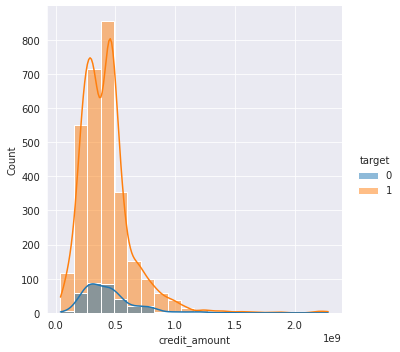

In [9]:
# distribution of successfull and unsuccessfull credit amounts respectively
sns.displot(data, x='credit_amount', kde=True, bins=20, hue='target')
sns.set_style("darkgrid")
#plt.xlim(0, 1.50e9)

In [10]:
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

scaler = RobustScaler() # Instanciate MinMaxScaler

data['credit_amount'] = scaler.fit_transform(data[['credit_amount']]) # Use scaler to transform data
data

,birth_date,credit_amount,salary_amount,region,gender,marital_status,credit_history,card_incomes_amount,target
0,08/12/1988,-0.459764,96800000,tashkent_city,M,married,no_credit_now,114000000,1
1,13/07/1994,-0.846179,180000000,tashkent_city,M,married,no_credit_now,194483333,1
2,18/12/1988,-0.788473,350000000,tashkent_city,M,not_married,no_credit_now,237583333,1
3,11/07/1984,-0.851503,300000000,tashkent_city,M,married,no_credit_now,248283333,1
4,25/03/1991,0.205276,700000000,andijan,M,married,no_credit_now,3819750000,1
...,...,...,...,...,...,...,...,...,...
3306,25/01/1980,0.239111,200000000,sirdarya,F,married,no_credit_now,203833333,1
3307,05/06/1988,0.089871,150000000,tashkent_city,M,married,no_credit_now,161900000,1
3308,22/05/1973,-0.447749,280000000,tashkent_city,F,not_married,has_credit_now,504333333,1
3309,15/10/1996,-0.394458,440000000,tashkent,M,married,has_credit_now,165600000,1


## Analysis by salary_amount

In [11]:
data.salary_amount.describe()

count    3.310000e+03
mean     2.642444e+08
std      2.053624e+08
min      4.000000e+05
25%      1.686875e+08
50%      2.300000e+08
75%      3.000000e+08
max      8.000000e+09
Name: salary_amount, dtype: float64

Outliers boundary: 500000000.0


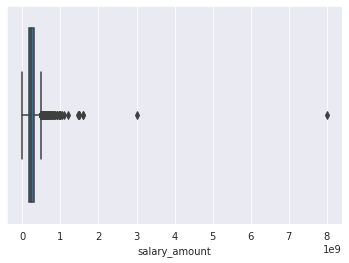

In [12]:
print('Outliers boundary:', data.salary_amount.quantile(0.95))
sns.boxplot(x=data["salary_amount"])
sns.set_style("darkgrid")

(0.0, 1000000000.0)

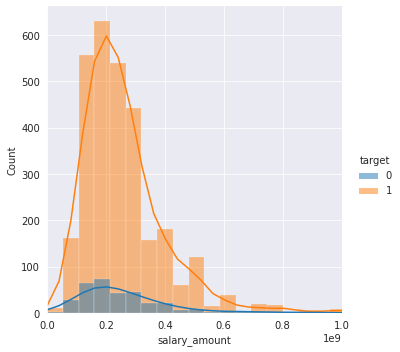

In [13]:
sns.displot(data, x='salary_amount', kde=True, bins=150, hue='target')
sns.set_style("darkgrid")
plt.xlim(0, 1.0e9)

In [14]:
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

scaler = RobustScaler() # Instanciate RobustScaler

data['salary_amount'] = scaler.fit_transform(data[['salary_amount']]) # Use scaler to transform data
data

,birth_date,credit_amount,salary_amount,region,gender,marital_status,credit_history,card_incomes_amount,target
0,08/12/1988,-0.459764,-1.014374,tashkent_city,M,married,no_credit_now,114000000,1
1,13/07/1994,-0.846179,-0.380771,tashkent_city,M,married,no_credit_now,194483333,1
2,18/12/1988,-0.788473,0.913851,tashkent_city,M,not_married,no_credit_now,237583333,1
3,11/07/1984,-0.851503,0.533079,tashkent_city,M,married,no_credit_now,248283333,1
4,25/03/1991,0.205276,3.579248,andijan,M,married,no_credit_now,3819750000,1
...,...,...,...,...,...,...,...,...,...
3306,25/01/1980,0.239111,-0.228463,sirdarya,F,married,no_credit_now,203833333,1
3307,05/06/1988,0.089871,-0.609234,tashkent_city,M,married,no_credit_now,161900000,1
3308,22/05/1973,-0.447749,0.380771,tashkent_city,F,not_married,has_credit_now,504333333,1
3309,15/10/1996,-0.394458,1.599238,tashkent,M,married,has_credit_now,165600000,1


## Analysis by regions

In [15]:
df_region = data.region.value_counts().to_frame()
df_region

,region
tashkent_city,1732
tashkent,748
sirdarya,479
jizzakh,129
samarkand,49
qashqadaryo,40
surxondaryo,24
fergana,23
namangan,19
bukhara,16


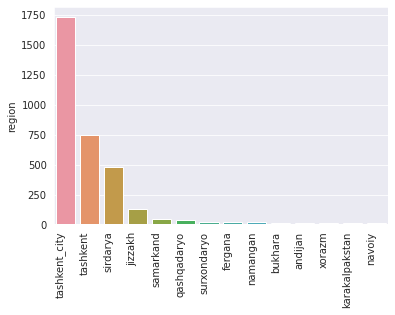

In [16]:
chart = sns.barplot(x=df_region.index, y=df_region.region)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='right')
sns.set_style("darkgrid")

In [17]:
from sklearn.preprocessing import OneHotEncoder

print(data.region.sort_values(ascending=True).unique())

ohe = OneHotEncoder(sparse = False) # Instanciate encoder

region_encoded = ohe.fit_transform(data[['region']]) # Encode alley

data["andijan"], data['bukhara'], data['fergana'], data['jizzakh'], data['karakalpakstan'], \
data['namangan'], data['navoiy'], data['qashqadaryo'], data['samarkand'], data['sirdarya'], \
data['surxondaryo'], data['tashkent'], data['tashkent_city'], data['xorazm'] = region_encoded.T

data.drop(columns='region', inplace=True)
data

['andijan' 'bukhara' 'fergana' 'jizzakh' 'karakalpakstan' 'namangan'
 'navoiy' 'qashqadaryo' 'samarkand' 'sirdarya' 'surxondaryo' 'tashkent'
 'tashkent_city' 'xorazm']


,birth_date,credit_amount,salary_amount,gender,marital_status,credit_history,card_incomes_amount,target,andijan,bukhara,...,karakalpakstan,namangan,navoiy,qashqadaryo,samarkand,sirdarya,surxondaryo,tashkent,tashkent_city,xorazm
0,08/12/1988,-0.459764,-1.014374,M,married,no_credit_now,114000000,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,13/07/1994,-0.846179,-0.380771,M,married,no_credit_now,194483333,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,18/12/1988,-0.788473,0.913851,M,not_married,no_credit_now,237583333,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,11/07/1984,-0.851503,0.533079,M,married,no_credit_now,248283333,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,25/03/1991,0.205276,3.579248,M,married,no_credit_now,3819750000,1,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,25/01/1980,0.239111,-0.228463,F,married,no_credit_now,203833333,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3307,05/06/1988,0.089871,-0.609234,M,married,no_credit_now,161900000,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3308,22/05/1973,-0.447749,0.380771,F,not_married,has_credit_now,504333333,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3309,15/10/1996,-0.394458,1.599238,M,married,has_credit_now,165600000,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Analysis by gender

M    0.581571
F    0.418429
Name: gender, dtype: float64


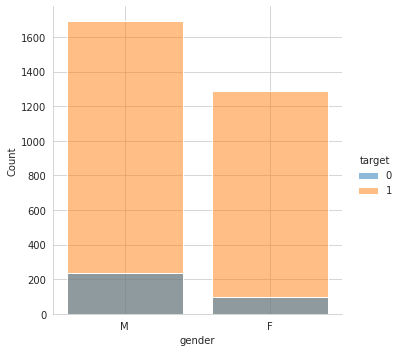

In [18]:
print(data.gender.value_counts()/len(data))
sns.set_style("whitegrid")
sns.displot(data, x="gender", hue='target', shrink=.8)

In [19]:
from sklearn.preprocessing import OrdinalEncoder

print(data.gender.sort_values(ascending=True).unique())

ore = OrdinalEncoder() # Instanciate encoder

data['M'] = ore.fit_transform(data[['gender']]) # Encode alley

data.drop(columns='gender', inplace=True)
data

['F' 'M']


,birth_date,credit_amount,salary_amount,marital_status,credit_history,card_incomes_amount,target,andijan,bukhara,fergana,...,namangan,navoiy,qashqadaryo,samarkand,sirdarya,surxondaryo,tashkent,tashkent_city,xorazm,M
0,08/12/1988,-0.459764,-1.014374,married,no_credit_now,114000000,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,13/07/1994,-0.846179,-0.380771,married,no_credit_now,194483333,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,18/12/1988,-0.788473,0.913851,not_married,no_credit_now,237583333,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,11/07/1984,-0.851503,0.533079,married,no_credit_now,248283333,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,25/03/1991,0.205276,3.579248,married,no_credit_now,3819750000,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,25/01/1980,0.239111,-0.228463,married,no_credit_now,203833333,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3307,05/06/1988,0.089871,-0.609234,married,no_credit_now,161900000,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3308,22/05/1973,-0.447749,0.380771,not_married,has_credit_now,504333333,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3309,15/10/1996,-0.394458,1.599238,married,has_credit_now,165600000,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## Analysis by marital_status

married        2695
not_married     391
divorced        132
widow            92
Name: marital_status, dtype: int64


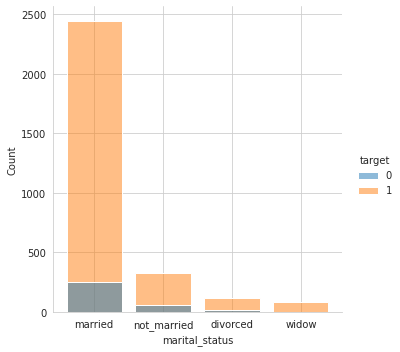

In [20]:
print(data.marital_status.value_counts())
sns.set_style("whitegrid")
sns.displot(data, x="marital_status", hue='target', shrink=.8)

In [21]:
from sklearn.preprocessing import OneHotEncoder

print(data.marital_status.sort_values(ascending=True).unique())  # Check unique values for streets (3)

ohe = OneHotEncoder(sparse = False) # Instanciate encoder

marital_status_encoded = ohe.fit_transform(data[['marital_status']]) # Encode alley

data["divorced"],data["married"],data['not_married'],data['widow'] = marital_status_encoded.T

data.drop(columns='marital_status', inplace=True)
data

['divorced' 'married' 'not_married' 'widow']


,birth_date,credit_amount,salary_amount,credit_history,card_incomes_amount,target,andijan,bukhara,fergana,jizzakh,...,sirdarya,surxondaryo,tashkent,tashkent_city,xorazm,M,divorced,married,not_married,widow
0,08/12/1988,-0.459764,-1.014374,no_credit_now,114000000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,13/07/1994,-0.846179,-0.380771,no_credit_now,194483333,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,18/12/1988,-0.788473,0.913851,no_credit_now,237583333,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,11/07/1984,-0.851503,0.533079,no_credit_now,248283333,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,25/03/1991,0.205276,3.579248,no_credit_now,3819750000,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,25/01/1980,0.239111,-0.228463,no_credit_now,203833333,1,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3307,05/06/1988,0.089871,-0.609234,no_credit_now,161900000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3308,22/05/1973,-0.447749,0.380771,has_credit_now,504333333,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3309,15/10/1996,-0.394458,1.599238,has_credit_now,165600000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Analysis by credit_history

no_credit_now     1788
has_credit_now    1522
Name: credit_history, dtype: int64


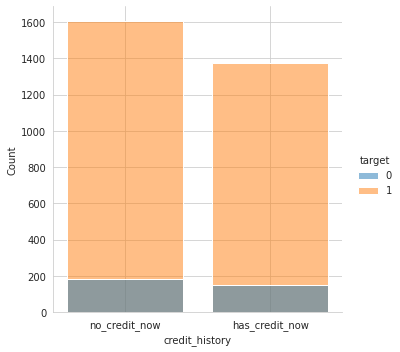

In [22]:
print(data.credit_history.value_counts())
sns.set_style("whitegrid")
sns.displot(data, x="credit_history", hue='target', shrink=.8)

In [23]:
from sklearn.preprocessing import OrdinalEncoder

print(data.credit_history.sort_values(ascending=True).unique())  # Check unique values for streets (3)

ore = OrdinalEncoder() # Instanciate encoder

data["no_credit_now"] = ore.fit_transform(data[['credit_history']]) # Encode alley

data.drop(columns='credit_history', inplace=True)
data

['has_credit_now' 'no_credit_now']


,birth_date,credit_amount,salary_amount,card_incomes_amount,target,andijan,bukhara,fergana,jizzakh,karakalpakstan,...,surxondaryo,tashkent,tashkent_city,xorazm,M,divorced,married,not_married,widow,no_credit_now
0,08/12/1988,-0.459764,-1.014374,114000000,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,13/07/1994,-0.846179,-0.380771,194483333,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,18/12/1988,-0.788473,0.913851,237583333,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,11/07/1984,-0.851503,0.533079,248283333,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,25/03/1991,0.205276,3.579248,3819750000,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,25/01/1980,0.239111,-0.228463,203833333,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3307,05/06/1988,0.089871,-0.609234,161900000,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3308,22/05/1973,-0.447749,0.380771,504333333,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3309,15/10/1996,-0.394458,1.599238,165600000,1,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## Analysis by card_incomes_amount

In [24]:
# card_incomes_amount column converted to numbers
data.card_incomes_amount = data.card_incomes_amount.str.replace(',', '.').astype('float').astype('int64')
data.card_incomes_amount

0        114000000
1        194483333
2        237583333
3        248283333
4       3819750000
           ...    
3306     203833333
3307     161900000
3308     504333333
3309     165600000
3310     608400000
Name: card_incomes_amount, Length: 3310, dtype: int64

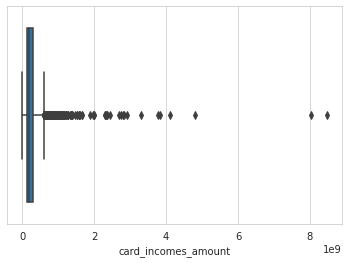

In [25]:
sns.boxplot(x=data["card_incomes_amount"])
sns.set_style("darkgrid")

(0.0, 2000000000.0)

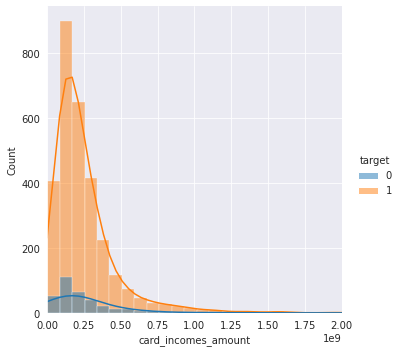

In [26]:
sns.displot(data, x='card_incomes_amount', kde=True, bins=100, hue='target')
sns.set_style("darkgrid")
plt.xlim(0, 2.0e9)

In [27]:
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

scaler = RobustScaler() # Instanciate MinMaxScaler

data['card_incomes_amount'] = scaler.fit_transform(data[['card_incomes_amount']]) # Use scaler to transform data
data

,birth_date,credit_amount,salary_amount,card_incomes_amount,target,andijan,bukhara,fergana,jizzakh,karakalpakstan,...,surxondaryo,tashkent,tashkent_city,xorazm,M,divorced,married,not_married,widow,no_credit_now
0,08/12/1988,-0.459764,-1.014374,-0.389236,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,13/07/1994,-0.846179,-0.380771,0.038242,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,18/12/1988,-0.788473,0.913851,0.267162,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,11/07/1984,-0.851503,0.533079,0.323994,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,25/03/1991,0.205276,3.579248,19.293409,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,25/01/1980,0.239111,-0.228463,0.087903,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3307,05/06/1988,0.089871,-0.609234,-0.134821,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3308,22/05/1973,-0.447749,0.380771,1.683973,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3309,15/10/1996,-0.394458,1.599238,-0.115168,1,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## Analysis by age (birth_date)

In [28]:
# Birth_date column converted to age for further analysis of credit holders' age
def age(born):
    born = datetime.strptime(born, "%d/%m/%Y").date()
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))
  
data['age'] = data['birth_date'].apply(age)

data.drop(columns='birth_date', inplace=True)
data

,credit_amount,salary_amount,card_incomes_amount,target,andijan,bukhara,fergana,jizzakh,karakalpakstan,namangan,...,tashkent,tashkent_city,xorazm,M,divorced,married,not_married,widow,no_credit_now,age
0,-0.459764,-1.014374,-0.389236,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,32
1,-0.846179,-0.380771,0.038242,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,27
2,-0.788473,0.913851,0.267162,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,32
3,-0.851503,0.533079,0.323994,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,37
4,0.205276,3.579248,19.293409,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,0.239111,-0.228463,0.087903,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,41
3307,0.089871,-0.609234,-0.134821,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,33
3308,-0.447749,0.380771,1.683973,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,48
3309,-0.394458,1.599238,-0.115168,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,25


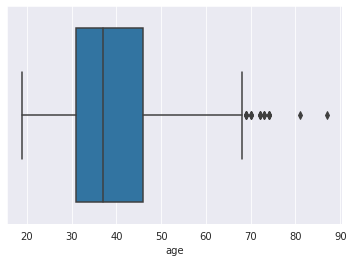

In [29]:
sns.boxplot(x=data["age"])
sns.set_style("darkgrid")

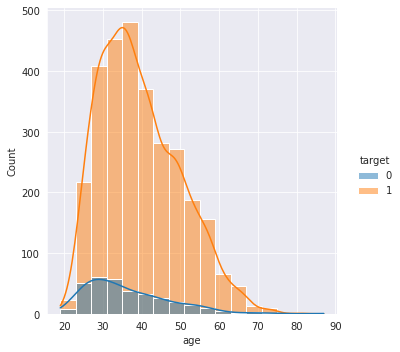

In [30]:
sns.displot(data, x='age', kde=True, bins=17, hue='target')
sns.set_style("darkgrid")

In [31]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

scaler = MinMaxScaler() # Instanciate MinMaxScaler

data['age'] = scaler.fit_transform(data[['age']]) # Use scaler to transform data
data

,credit_amount,salary_amount,card_incomes_amount,target,andijan,bukhara,fergana,jizzakh,karakalpakstan,namangan,...,tashkent,tashkent_city,xorazm,M,divorced,married,not_married,widow,no_credit_now,age
0,-0.459764,-1.014374,-0.389236,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.191176
1,-0.846179,-0.380771,0.038242,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.117647
2,-0.788473,0.913851,0.267162,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.191176
3,-0.851503,0.533079,0.323994,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.264706
4,0.205276,3.579248,19.293409,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.161765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,0.239111,-0.228463,0.087903,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.323529
3307,0.089871,-0.609234,-0.134821,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.205882
3308,-0.447749,0.380771,1.683973,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.426471
3309,-0.394458,1.599238,-0.115168,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.088235


# Feature engineering

In [32]:
data

,credit_amount,salary_amount,card_incomes_amount,target,andijan,bukhara,fergana,jizzakh,karakalpakstan,namangan,...,tashkent,tashkent_city,xorazm,M,divorced,married,not_married,widow,no_credit_now,age
0,-0.459764,-1.014374,-0.389236,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.191176
1,-0.846179,-0.380771,0.038242,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.117647
2,-0.788473,0.913851,0.267162,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.191176
3,-0.851503,0.533079,0.323994,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.264706
4,0.205276,3.579248,19.293409,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.161765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,0.239111,-0.228463,0.087903,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.323529
3307,0.089871,-0.609234,-0.134821,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.205882
3308,-0.447749,0.380771,1.683973,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.426471
3309,-0.394458,1.599238,-0.115168,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.088235
